# Importing

In [2]:
import pandas as pd
import yfinance as yf
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout , TimeDistributed , Conv1D , MaxPooling1D , Flatten , Bidirectional
from keras.callbacks import ModelCheckpoint
import pickle
import matplotlib.pyplot as plt

# Getting data via yfinance API

In [3]:
stock = yf.Ticker("RELIANCE.NS")
df = stock.history(period='1d',
start = datetime.date.today() - relativedelta(years=5),end = datetime.date.today())

# Taking only closing price column

In [4]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-06-18 00:00:00+05:30,977.938040,989.231616,976.193064,984.481506,5705952,0.0,0.0
2018-06-19 00:00:00+05:30,982.881968,983.754486,963.251509,965.578064,6406255,0.0,0.0
2018-06-20 00:00:00+05:30,965.529586,991.606631,964.414749,988.068298,7262014,0.0,0.0
2018-06-21 00:00:00+05:30,992.139759,1004.305852,990.055583,1000.379761,10609377,0.0,0.0
2018-06-22 00:00:00+05:30,996.938449,997.713968,977.598749,981.524841,16323253,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-12 00:00:00+05:30,2475.500000,2489.199951,2465.000000,2484.149902,2949893,0.0,0.0
2023-06-13 00:00:00+05:30,2495.000000,2523.449951,2486.250000,2520.850098,5190958,0.0,0.0
2023-06-14 00:00:00+05:30,2521.000000,2555.000000,2517.000000,2551.850098,6127509,0.0,0.0


In [3]:
df_minmax = df.iloc[:,3:4]

In [4]:
min_max = MinMaxScaler(feature_range=(0,1))
df_minmax = min_max.fit_transform(df_minmax)

In [5]:
training_size=int(len(df_minmax)*0.65)
test_size=len(df_minmax)-training_size
train_data,test_data=df_minmax[0:training_size,:],df_minmax[training_size:len(df_minmax),:1]

In [6]:
def makeFeature(data,feature=24):
    x = list()
    y = list()
    for i in range(len(data)-feature-1):
        x.append(data[i:(i + feature),0])
        y.append(data[i + feature,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [7]:
x_train,y_train = makeFeature(train_data)

In [8]:
x_test,y_test = makeFeature(test_data)

In [9]:
x_train.shape[0]

779

In [10]:
x_train.shape[1]

24

In [11]:
x_train = np.reshape(x_train,(x_train.shape[0],1,24,1))

In [12]:
x_test = np.reshape(x_test,(x_test.shape[0],1,24,1))

In [13]:
x_train.shape

(779, 1, 24, 1)

In [14]:
x_test.shape

(408, 1, 24, 1)

# Making Model

In [ ]:
model = Sequential([
    TimeDistributed(Conv1D(filters = 6,kernel_size = 3, activation = 'relu'),input_shape=(None, 24, 1)),
    TimeDistributed(MaxPooling1D()),
    TimeDistributed(Flatten()),
    LSTM(100,return_sequences=False,input_shape=(x_train.shape[1],1)),
    Dropout(0.42),
#     LSTM(50,return_sequences=False),
#     Dropout(0.3),
    Dense(1)
])
model.compile(optimizer='adam',loss='mean_squared_error')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 22, 6)      24        
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 11, 6)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 66)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               66800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                        

# Define Model Checkpoint

In [17]:
checkpoint = ModelCheckpoint(filepath='model.hdf5',
                             verbose=1,
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True)

In [ ]:
stock_price = model.fit(x_train,y_train,epochs=100,batch_size=24,verbose=1,callbacks=checkpoint)

# Predicting 

In [19]:
train_predict=model.predict(x_train)
test_predict=model.predict(x_test)

13/13 [==============================] - 0s 1ms/step


In [20]:
train_predict=min_max.inverse_transform(train_predict)
test_predict=min_max.inverse_transform(test_predict)

# Plotting 
### shift train predictions for plotting

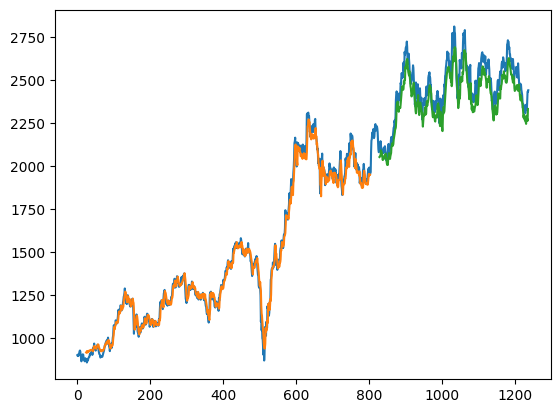

In [21]:
look_back=24
trainPredictPlot = np.empty_like(df_minmax)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_minmax)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_minmax)-1, :] = test_predict
# plot baseline and predictions
plt.plot(min_max.inverse_transform(df_minmax))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Save both min-max and CNN-LSTM model

In [ ]:
pickle.dump(model, open('model_val_best.pkl', 'wb'))

In [ ]:
pickle.dump(min_max,open('minmax.pkl','wb'))